# Exploratory Data Analysis

This notebook contains basic data analysis on the Wiki-727k and podcast datasets. The intent is to gather information about the underlying structure and characteristics of each dataset. This notebook requires the raw text files to be located in the data directory with the following structure
```bash
├── SliceCast/
│   ├── data/
│   │   ├── podcasts/
│   │   └── wiki-sample/
```
Included in this repository are both the podcast and wiki-sample text files. The podcasts are in raw .txt form and need not be modified, but the wiki-samples are located in a zip file and must be unzipped as there are 1000 files within the zip. 

In [1]:
import numpy as np
import pandas as pd
import spacy
from pathlib import Path
import random
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from src.spacyOps import createInferencePipe


print(spacy.__version__)

2.1.3


First we would like to run spacy NLP on each of the documents
that we have randomly sampled from the larger dataset. Because they
have been sampled at random, we expect that they will be representative
of the entire dataset.

In [2]:
nlp = createInferencePipe()

wikiDataPath = Path('./data/wiki-sample')
wikiFiles = [x for x in wikiDataPath.glob('**/*.txt') if x.is_file()]

In [3]:
print('There are {} files in the wiki-sample directory'.format(len(wikiFiles)))
print('Running SpaCy NLP on the files (this can take up to 5 minutes)')
wikiDocs = [nlp(fo.read_text(encoding='utf-8')) for fo in wikiFiles]

There are 1000 files in the wiki-sample directory
Running SpaCy NLP on the files (this can take up to 5 minutes)


In [4]:
podcastDataPath = Path('./data/podcasts')
podcastFiles = [x for x in podcastDataPath.glob('**/*.txt') if x.is_file()]

print('There are {} files in the podcast directory'.format(len(podcastFiles)))
print('Running SpaCy NLP on the files (this will take a few minutes)')

podcastDocs = [nlp(fo.read_text(encoding='utf-8')) for fo in podcastFiles]

There are 47 files in the podcast directory
Running SpaCy NLP on the files (this will take a few minutes)


First let's provide some stucture by organizing our documents into a
pandas dataframe

In [5]:
wiki_df = pd.DataFrame()
wiki_df['doc_name'] = [str(x.stem) for x in wikiFiles]
print(wiki_df.head())

pod_df = pd.DataFrame()
pod_df['doc_name'] = [str(x.stem) for x in podcastFiles]
print(pod_df.head())

  doc_name
0  2061318
1  6416879
2  2838306
3   574933
4   118427
  doc_name
0   katy94
1   tim362
2   katy92
3  katy115
4   katy81


Next let's compare some key characteristics about the 2 datasets

Number of words - Right away, we can see that the podcasts are much longer
on average than the wiki articles.

In [6]:
wiki_num_words = [len(x) for x in wikiDocs]
wiki_df['num_words'] = wiki_num_words

pod_num_words = [len(x) for x in podcastDocs]
pod_df['num_words'] = pod_num_words

In [7]:
# Let's add our spacy tokenized sentences and corresponding labels to the dataframe
# number of sentences

label_arr = []
sent_arr = []
for doc in wikiDocs:
    labels = np.array(doc.user_data['labels'])
    sents = np.array(doc.user_data['sents'], dtype=object)
    label_arr.append(labels)
    sent_arr.append(sents)

wiki_df['sents'] = sent_arr
wiki_df['labels'] = label_arr

label_arr = []
sent_arr = []
for doc in podcastDocs:
    labels = np.array(doc.user_data['labels'])
    sents = np.array(doc.user_data['sents'], dtype=object)
    label_arr.append(labels)
    sent_arr.append(sents)

pod_df['sents'] = sent_arr
pod_df['labels'] = label_arr

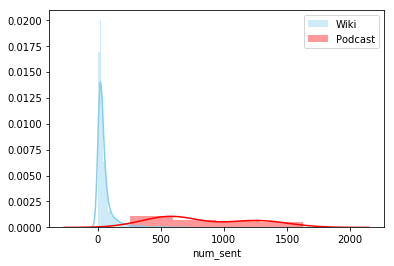

In [8]:
wiki_df['num_sent'] = wiki_df.apply(lambda row: len(row.sents), axis=1)
pod_df['num_sent'] = pod_df.apply(lambda row: len(row.sents), axis=1)

sns.distplot( wiki_df['num_sent'] , color="skyblue", label='Wiki')
sns.distplot( pod_df['num_sent'] , color="red", label='Podcast')
plt.legend()
plt.show()


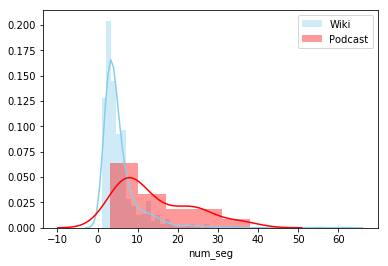

In [9]:
# number of segments
wiki_df['num_seg'] = wiki_df.apply(lambda row: sum(row.labels), axis=1)
pod_df['num_seg'] = pod_df.apply(lambda row: sum(row.labels), axis=1)

sns.distplot( wiki_df['num_seg'] , color="skyblue", label='Wiki')
sns.distplot( pod_df['num_seg'] , color="red", label='Podcast')
plt.legend()
plt.show()

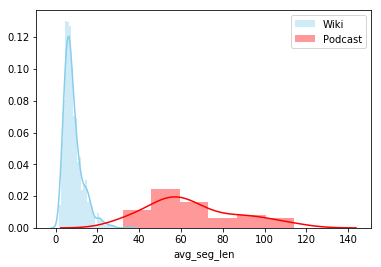

The median segment length for wiki is 7.000
The median segment length for podcasts is 59.556


In [10]:
# average segment length
wiki_df['avg_seg_len'] = wiki_df.apply(lambda row: row.num_sent/row.num_seg, axis=1)
pod_df['avg_seg_len'] = pod_df.apply(lambda row: row.num_sent/row.num_seg, axis=1)
pod_df = pod_df.mask((pod_df['avg_seg_len'] - pod_df['avg_seg_len'].mean()).abs() > 2 * pod_df['avg_seg_len'].std())
pod_df = pod_df.dropna()


sns.distplot( wiki_df['avg_seg_len'] , color="skyblue", label='Wiki')
sns.distplot( pod_df['avg_seg_len'] , color="red", label='Podcast')
plt.legend()
plt.show()

avg_seg_wiki = wiki_df['avg_seg_len'].median()
avg_seg_pod = pod_df['avg_seg_len'].median()
print('The median segment length for wiki is {:0.3f}'.format(avg_seg_wiki))
print('The median segment length for podcasts is {:0.3f}'.format(avg_seg_pod))